In [7]:
# Data Loader
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
from pytorch_lightning.utilities.types import EVAL_DATALOADERS, TRAIN_DATALOADERS
import pytorch_lightning as pl
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch.utils.data import random_split
import json
#from CustomDataset import * 
from Horizon_DataLoader import * 
import sys
sys.path.append('../')
from config import *
from file_helper import *
#from Horizon_and_SAM.Horizon import PE_helper
from  PE_helper import *

from pytorch_lightning.callbacks import ModelCheckpoint , Callback

def collate_fn(batch):
    return tuple(zip(*batch))
#=================================
#             Augmentation
#=================================

class CustomDataModule(pl.LightningDataModule):
    def __init__(self ,
                 train_dir ,
                 test_dir , batch_size = 2,
                 num_workers = 0 , img_size=[IMG_WIDTH, IMG_HEIGHT] , use_aug = True ,padding_count = 24 ,c =0.1
                   ):
        super().__init__()
        self.train_dir = train_dir
        self.test_dir = test_dir
        
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.img_size = img_size      
        self.use_aug = use_aug
        self.padding_count  = padding_count
        self.c = c
        

        pass

    def prepare_data(self) -> None:
        # Download dataset
        pass

    def setup(self, stage):
        # Create dataset...          
                
        self.entire_dataset = CustomDataset(self.train_dir  , use_aug= self.use_aug ,  c=self.c , img_size=self.img_size)
        self.train_ds , self.val_ds = random_split(self.entire_dataset , [0.9, 0.1])        
        self.test_ds = CustomDataset(self.test_dir  , use_aug= False , img_size=self.img_size  )
        
        print("image size ",self.img_size)
        pass

    # ToDo: Reture Dataloader...
    def train_dataloader(self) -> TRAIN_DATALOADERS:
        return DataLoader(self.train_ds , batch_size= self.batch_size , num_workers= self.num_workers , shuffle=True)
    
    def val_dataloader(self) -> EVAL_DATALOADERS:
        return DataLoader(self.val_ds , batch_size= self.batch_size , num_workers= self.num_workers , shuffle=False)
    
    def test_dataloader(self) -> EVAL_DATALOADERS:
        return DataLoader(self.test_ds , batch_size= self.batch_size , num_workers= self.num_workers , shuffle=True)

    pass


# Test
dm = CustomDataModule ( train_dir= f"../anno/test_visiable_10_no_cross.json" ,
                       test_dir= f"../anno/test_visiable_10_no_cross.json" , padding_count=1024, c =0.96,  img_size=[1024,512]
                       )


In [8]:
from scipy.ndimage.filters import maximum_filter
def find_N_peaks2(signal, r=29, min_v=0.05, N=None):
    max_v = maximum_filter(signal, size=r, mode='wrap')

    #plt.imshow(np.tile(max_v.reshape(1,-1) , (50 ,1) ) , cmap='gray')
    #plt.axis('off')
    #plt.title("max_v")
    #plt.show()

    pk_loc = np.where(max_v == signal)[0]
    if(min_v>0):
        pk_loc = pk_loc[signal[pk_loc] > min_v]
    if N is not None:
        order = np.argsort(-signal[pk_loc])
        pk_loc = pk_loc[order[:N]]
        pk_loc = pk_loc[np.argsort(pk_loc)]
    return pk_loc, signal[pk_loc]


#a = np.random.randn(1024)
#a = np.random.randn(1024) 
a = np.arange(1024) /1024 -0.5
a = a * np.sin(a *5) +np.random.randn(1024) *0.25

print(a)
pk_loc , signal = find_N_peaks2(a, r= 0 )
pk_loc , signal = find_N_peaks2(a, r= 1 )
pk_loc , signal = find_N_peaks2(a, r= 5 )
print(pk_loc.shape)
print(pk_loc)
print(signal)

[0.41896551 0.47652863 0.54748358 ... 0.24537386 0.06550919 0.10284338]
(199,)
[   2    9   12   17   21   25   31   35   38   44   48   53   56   61
   65   71   77   80   84   90   94   99  102  108  113  116  121  131
  134  139  144  147  152  160  165  173  176  182  186  198  202  210
  213  218  223  228  233  238  242  245  249  254  259  263  267  273
  278  285  292  295  298  302  305  311  317  321  332  339  347  351
  356  364  367  373  378  383  388  393  397  402  413  417  421  429
  442  449  456  459  464  468  471  479  485  489  494  499  502  505
  519  524  537  540  544  550  554  563  571  575  586  590  594  598
  602  606  612  616  620  624  627  634  637  640  643  649  654  660
  664  668  672  677  683  689  693  700  704  707  714  723  729  732
  735  739  742  746  749  755  758  767  772  777  782  786  795  798
  801  805  809  812  816  821  824  828  831  836  844  849  856  860
  863  870  874  881  888  894  898  902  906  909  915  922  927  93

Using 16bit None Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Testing DataLoader 0:   0%|          | 25/6249 [12:57<53:46:31, 31.10s/it]
image size  [1024, 512]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 1563/1563 [16:40<00:00,  1.56it/s]ap_0.05 0.8515107406453739
ap_0.5 0.7682285179222905
ap_0.75 0.5259322687433281
all_iou 9775.81888892129
mIOU 0.7552977585506676


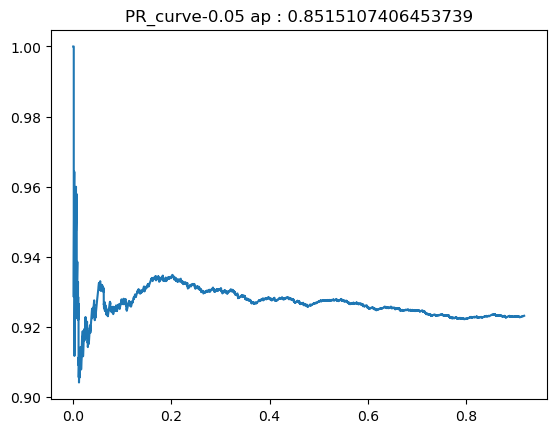

all_iou 9775.81888892129
mIOU 0.7552977585506676


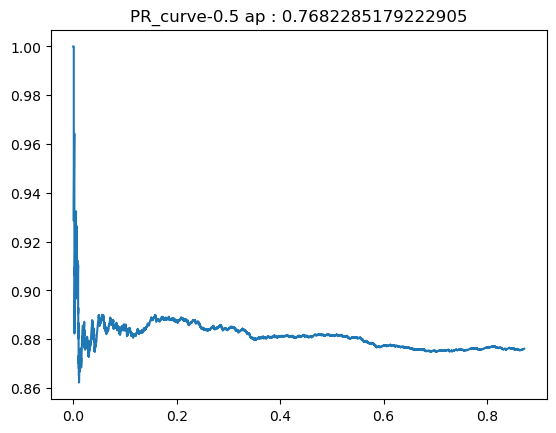

all_iou 9775.81888892129
mIOU 0.7552977585506676


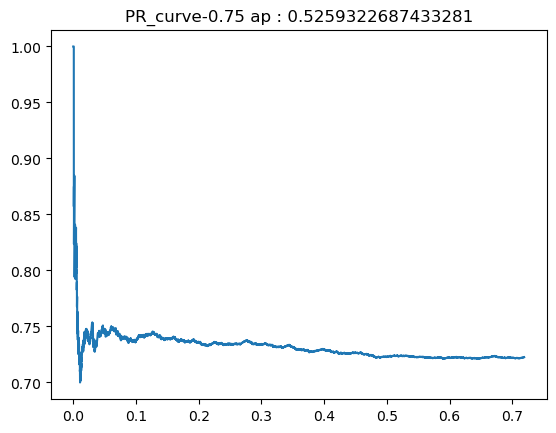

Testing DataLoader 0: 100%|██████████| 1563/1563 [16:40<00:00,  1.56it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      Eval/AUC_0.05         0.8515107406453739
      Eval/AUC_0.5          0.7682285179222905
      Eval/AUC_0.75         0.5259322687433281
Eval/Precision_rate_0.05    0.9232083236276108
 Eval/Precision_rate_0.5    0.8760773351968321
Eval/Precision_rate_0.75    0.7225716282320056
  Eval/Recall_rate_0.05     0.9186432820829792
  Eval/Recall_rate_0.5      0.8717453449741173
  Eval/Recall_rate_0.75     0.7189986865487136
        Eval/mIou           0.7552977585506676
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'Eval/Precision_rate_0.05': 0.9232083236276108,
  'Eval/Recall_rate_0.05': 0.9186432820829792,
  'Eval/AUC_0.05': 0.8515107406453739,
  'Eval/mIou': 0.7552977585506676,
  'Eval/Precision_rate_0.5': 0.8760773351968321,
  'Eval/Recall_rate_0.5': 0.8717453449741173,
  'Eval/AUC_0.5': 0.7682285179222905,
  'Eval/Precision_rate_0.75': 0.7225716282320056,
  'Eval/Recall_rate_0.75': 0.7189986865487136,
  'Eval/AUC_0.75': 0.5259322687433281}]

In [33]:
from raw_model_pixelwize_bbox import *
from Horizon_DataLoader import  * 
import pytorch_lightning as pl
import torch
import torch.nn.functional as F
from scipy.optimize import linear_sum_assignment
from scipy.spatial import distance
from PE_helper import * 
from torch import Tensor
def unpad_data( x :[Tensor] ) :
	non_zero_indices = torch.nonzero(x)
	#print(non_zero_indices)
	# Get the non-zero values
	non_zero_values = x[non_zero_indices[:,0], non_zero_indices[:,1]]

	unique = torch.unique(non_zero_indices[:,0] ,return_counts=True)	
	non_zero_values = torch.split(non_zero_values , tuple(unique[1]))
	
	return non_zero_values
@torch.no_grad()
def pack_visualize( gt_u_b , gt_vtop_b , gt_vbtm_b , gt_du_b , gt_dvtop_b , dv_btm_b ):
    
    if isinstance(gt_u_b, torch.Tensor):
        sizes = [t.numel() for t in gt_u_b]               
        us = gt_u_b.flatten().unsqueeze(0).repeat(2, 1).permute(1,0).reshape(-1)
        us[1::2]+=gt_du_b.flatten()
        us = torch.split(us.view(-1,2) , sizes)

        tops = gt_vtop_b.flatten().unsqueeze(0).repeat(2, 1).permute(1,0).reshape(-1)
        tops[1::2]=gt_dvtop_b.flatten()
        tops = torch.split(tops.view(-1,2) , sizes)

        btms = gt_vbtm_b.flatten().unsqueeze(0).repeat(2, 1).permute(1,0).reshape(-1)
        btms[1::2]=dv_btm_b.flatten()
        btms = torch.split(btms.view(-1,2) , sizes)

    elif isinstance(gt_u_b, tuple) and all(isinstance(t, torch.Tensor) for t in gt_u_b):        
        sizes = [len(t) for t in gt_u_b]               
        us = torch.cat(gt_u_b).view(-1).unsqueeze(0).repeat(2, 1).permute(1,0).reshape(-1)
        us[1::2]+=torch.cat(gt_du_b).view(-1)
        us = torch.split(us.view(-1,2) , sizes)

        tops = torch.cat(gt_vtop_b).view(-1).unsqueeze(0).repeat(2, 1).permute(1,0).reshape(-1)
        tops[1::2]=torch.cat(gt_dvtop_b).view(-1)
        tops = torch.split(tops.view(-1,2) , sizes)

        btms = torch.cat(gt_vbtm_b).view(-1).unsqueeze(0).repeat(2, 1).permute(1,0).reshape(-1)
        btms[1::2]=torch.cat(dv_btm_b).view(-1)
        btms = torch.split(btms.view(-1,2) , sizes)
    else:
        assert("Wrong Type.")
    
    return us , tops ,btms

class Model(pl.LightningModule):    
    def __init__(self , r = 29 , confidence_threshold = 0.5 , output_log_name = "out"):
        super().__init__()
        self.model = HorizonNet(backbone='resnet50', use_rnn=True)
        self.log_folder = os.path.join(os.getcwd() , "all_0227" )
        self.post_thrshold = confidence_threshold
        self.max_filter_r = r

        self.output_log_name = output_log_name
        self.output_log =[]
        
    def forward(self , x):
        prob , boxs  = self.model(x)  # [ b , _ , 1024]
        prob = prob.permute((0,2,1))
        boxs = boxs.permute((0,2,1))
        

        return prob , boxs
        pass
    def __common_stepup(self , input_b):
        img = input_b['image']        

        gt_u_b = unpad_data( input_b['u'])          
        gt_vtop_b =unpad_data(input_b['v_top'])
        gt_vbtm_b = unpad_data (input_b['v_btm'])
        gt_du_b = unpad_data(input_b['du'])
        gt_dvtop_b = unpad_data(input_b['dv_top'])
        gt_dv_btm_b = unpad_data(input_b['dv_btm'])

        out_prob , out_boxs = self.forward(img)
        batch_size = out_prob.shape[0]

        return gt_u_b , gt_vtop_b , gt_vbtm_b , gt_du_b , gt_dvtop_b , gt_dv_btm_b , out_prob ,out_boxs, batch_size
        pass
    def training_step(self , input_b ,batch_idx ):
        img = input_b['image']
        
        gt_pro = input_b['u_grad']
        gt_u_b , gt_vtop_b , gt_vbtm_b , gt_du_b , gt_dvtop_b , gt_dv_btm_b , out_prob ,out_boxs, batch_size = self.__common_stepup(input_b)
        
        total_loss = 0
        b_cnt = 0
        for u,vtop,vbtm,du,dvtop, dvbtm , pred_cls , pred_box , gt_cls in zip(gt_u_b , gt_vtop_b , gt_vbtm_b , gt_du_b , gt_dvtop_b , gt_dv_btm_b , out_prob , out_boxs , gt_pro):
            gt_box =  torch.vstack([ u, vtop,vbtm,  du ,dvtop , dvbtm]).permute(1,0)   # [n , 6]  
            gt_cnt = gt_box.shape[0]

            # Select n peak column
            pkloc , signal = find_N_peaks2( pred_cls.detach().cpu().numpy().astype(np.float32).flatten() , r= self.max_filter_r, min_v=-2, N=gt_cnt)            
            pred_u = pkloc / 1024
            #print("pkloc" , pkloc)
            #print("pred_u" , pred_u)
            #print("gt u" , u)
            
            # Match gt for each selected peak
            u_cdist =distance.cdist( np.expand_dims(pred_u, axis=-1),  u.unsqueeze(-1).detach().cpu().numpy() )
            row_idx , col_idx = linear_sum_assignment ( u_cdist )

            #print("row_idx " , row_idx)
            #print("col_idx" , col_idx)
            #print("pred_box[row_idx]" , pred_box[row_idx])
            #print("gt_box[col_idx]" , gt_box[col_idx])
            l1_loss = F.l1_loss(pred_box[pkloc][row_idx] , gt_box[col_idx,1:]   )         
            total_loss += l1_loss / gt_cnt

            with torch.no_grad():
                if batch_idx % 5 ==0:
                #if self.current_epoch > 0 and self.current_epoch % 5 == 0  and batch_idx <5 :                
                    save_path =  os.path.join(self.log_folder , f"gt_ep_{self.current_epoch}-{self.global_step}-{batch_idx}" )                    
                    # View GT
                    gt_us , gt_tops , gt_btms = pack_visualize(u.view(1 , -1 ) , vtop , vbtm , du , dvtop , dvbtm )                   
                    vis_imgs = visualize_2d_single(gt_us , gt_tops , gt_btms , u_grad =  gt_cls.view(1 , -1 ), imgs= img[b_cnt] , title="GT",save_path=save_path )                
                    #plt.imshow(vis_imgs)                    
                    #plt.show()
                    
                    # View Prediction
                    #decode_pred = decode_pred_b[row_idx]
                    decode_pred = pred_box[pkloc][row_idx].detach().cpu()
                    save_path =  os.path.join(self.log_folder , f"pred_ep_{self.current_epoch}-{self.global_step}-{batch_idx}" )
                    pred_us , pred_tops , pred_btms = pack_visualize( torch.as_tensor(pred_u[row_idx]) , decode_pred[:,0],decode_pred[:,1],
                                                                          decode_pred[:,2] ,decode_pred[:,3],decode_pred[:,4] )                    
                    vis_imgs = visualize_2d_single(pred_us , pred_tops , pred_btms , u_grad = F.sigmoid(pred_cls).view(1 , -1 ) , imgs=  img[b_cnt] ,
                                                    title=f"Pred_row{row_idx}-\n u:{pred_us}" , save_path= save_path  )
                    #plt.imshow(vis_imgs)                    
                    #plt.show()
                pass
            b_cnt+=1
        total_loss/= batch_size
        
        cls_loss = F.binary_cross_entropy_with_logits(out_prob.view(batch_size , -1) , gt_pro.view(batch_size , -1))
        self.log(f"train_cls_loss" , cls_loss)
        self.log(f"train_box_loss" , total_loss)
        total_loss += cls_loss 
        self.log(f"train_total_loss" , total_loss)
        #print("cls_loss" , cls_loss)
        #print("total_loss" , total_loss)
        return total_loss
    
    def validation_step(self, input_b, batch_idx):        
        img = input_b['image']
        
        gt_pro = input_b['u_grad']
        gt_u_b , gt_vtop_b , gt_vbtm_b , gt_du_b , gt_dvtop_b , gt_dv_btm_b , out_prob ,out_boxs, batch_size = self.__common_stepup(input_b)
        
        total_loss = 0
        b_cnt = 0
        for u,vtop,vbtm,du,dvtop, dvbtm , pred_cls , pred_box , gt_cls in zip(gt_u_b , gt_vtop_b , gt_vbtm_b , gt_du_b , gt_dvtop_b , gt_dv_btm_b , out_prob , out_boxs , gt_pro):
            gt_box =  torch.vstack([ u, vtop,vbtm,  du ,dvtop , dvbtm]).permute(1,0)   # [n , 6]  
            gt_cnt = gt_box.shape[0]

            # Select n peak column
            pkloc , signal = find_N_peaks2( pred_cls.detach().cpu().numpy().astype(np.float32).flatten() , r = self.max_filter_r , min_v=self.post_thrshold, N=None)            
            pred_u = pkloc / 1024
            
            # Match gt for each selected peak
            u_cdist =distance.cdist( np.expand_dims(pred_u, axis=-1),  u.unsqueeze(-1).detach().cpu().numpy() )
            row_idx , col_idx = linear_sum_assignment ( u_cdist )

            l1_loss = F.l1_loss(pred_box[pkloc][row_idx] , gt_box[col_idx,1:]   )         
            total_loss += l1_loss / row_idx.shape[0] +  abs(gt_cnt - row_idx.shape[0])

            with torch.no_grad():
                if batch_idx % 5 ==0:
                #if self.current_epoch > 0 and self.current_epoch % 5 == 0  and batch_idx <5 :                
                    save_path =  os.path.join(self.log_folder , f"val_gt_ep_{self.current_epoch}-{self.global_step}-{batch_idx}" )                    
                    # View GT
                    gt_us , gt_tops , gt_btms = pack_visualize(u.view(1 , -1 ) , vtop , vbtm , du , dvtop , dvbtm )                   
                    vis_imgs = visualize_2d_single(gt_us , gt_tops , gt_btms , u_grad =  gt_cls.view(1 , -1 ), imgs= img[b_cnt] , title="GT",save_path=save_path )                
                    #plt.imshow(vis_imgs)                    
                    #plt.show()
                    
                    # View Prediction
                    #decode_pred = decode_pred_b[row_idx]
                    decode_pred = pred_box[pkloc][row_idx].detach().cpu()
                    save_path =  os.path.join(self.log_folder , f"val_pred_ep_{self.current_epoch}-{self.global_step}-{batch_idx}" )
                    pred_us , pred_tops , pred_btms = pack_visualize( torch.as_tensor(pred_u[row_idx]) , decode_pred[:,0],decode_pred[:,1],
                                                                          decode_pred[:,2] ,decode_pred[:,3],decode_pred[:,4] )                    
                    vis_imgs = visualize_2d_single(pred_us , pred_tops , pred_btms , u_grad = F.sigmoid(pred_cls).view(1 , -1 ) , imgs=  img[b_cnt] ,
                                                    title=f"Pred_row{row_idx}-\n u:{pred_us}" , save_path= save_path  )
                    #plt.imshow(vis_imgs)                    
                    #plt.show()
                pass
            b_cnt+=1
        total_loss/= batch_size
        
        cls_loss = F.binary_cross_entropy_with_logits(out_prob.view(batch_size , -1) , gt_pro.view(batch_size , -1))
        self.log(f"val_cls_loss" , cls_loss)
        self.log(f"val_box_loss" , total_loss)
        total_loss += cls_loss 
        self.log(f"val_total_loss" , total_loss)
        
        print("[val] total_loss" , total_loss)
        return total_loss
    
    def reset_eval_helper(self ):        
        self.eval_helper = PR_Eval_Helper(get_iou_fn= get_iou_matrix_polygon)
        pass
    @torch.no_grad()
    def __calculate_pr(self):
        assert self.eval_helper is not None , "eval_helper not reset"
        self.eval_helper.get_all_pr(self)

        self.eval_helper = None
        pass

    def on_test_epoch_start(self):
        self.output_log = []
        self.reset_eval_helper()
    def on_test_epoch_end(self):
        self.__calculate_pr()

        # write output log file
        log_save_folder = create_folder(os.path.join(os.getcwd() , "output_log" ))
        log_save_file = os.path.join(log_save_folder , f"{self.output_log_name}.json")
        
        json_object = json.dumps(self.output_log)         
        with open(log_save_file, "w") as outfile:
            outfile.write(json_object)

    @torch.no_grad()
    def test_step(self, input_b, batch_idx):
        EVAL_PIXEL_MASK_WIDTH = 1024
        EVAL_PIXEL_MASK_HEIGHT = 512

        imgs = input_b['image']       
        img_paths =  input_b['image_path']
        
        gt_pro = input_b['u_grad']
        
        gt_u_b , gt_vtop_b , gt_vbtm_b , gt_du_b , gt_dvtop_b , gt_dv_btm_b , out_prob ,out_boxs, batch_size = self.__common_stepup(input_b)
        b_cnt = 0
        output_log =[]

        # [ Prediction Output ]
        for b_cnt , img in enumerate( imgs):
            predictions= []
            gts= []
        
            pred_box = out_boxs[b_cnt]
            pred_cls = out_prob[b_cnt]
            # Select n peak column
            pkloc , signal = find_N_peaks2( pred_cls.detach().cpu().numpy().astype(np.float32).flatten() , r=self.max_filter_r , min_v=self.post_thrshold, N=None)                        
            pred_u = pkloc / 1024
            
            # View Prediction---------------------------------------------------------------
            ''''''
            decode_pred = pred_box[pkloc].clone().detach().cpu()
            
            save_path =  os.path.join(self.log_folder , f"val_pred_ep_{self.current_epoch}-{self.global_step}-{batch_idx}" )
            pred_us , pred_tops , pred_btms = pack_visualize( torch.as_tensor(pred_u[:]) , decode_pred[:,0],decode_pred[:,1],
                                                                          decode_pred[:,2] ,decode_pred[:,3],decode_pred[:,4] )                    
            '''
            vis_imgs = visualize_2d_single(pred_us , pred_tops , pred_btms , u_grad = F.sigmoid(pred_cls).view(1 , -1 ) , imgs=  img ,
                                                    title=f"Pred_row{pkloc}-\n u:{pred_us}" , save_path= save_path  )
            plt.imshow(vis_imgs)                 
            plt.title("pred vis")   
            plt.show()  
            '''


            debug_img = np.ascontiguousarray( img.permute(1,2,0).detach().cpu().numpy())
            for u , vt,vb in zip( pred_us , pred_tops , pred_btms):                                            
                #polys , debug_img  = to_distorted_box(u,vt,vb , return_mask= False ,
                polys   = to_distorted_box(u,vt,vb , return_mask= False ,
                                                h =EVAL_PIXEL_MASK_HEIGHT ,
                                                w = EVAL_PIXEL_MASK_WIDTH , 
                                                image= debug_img,
                                                seg_count=30 , show_plt=False , return_img=False , fill_color=(255,0,0))
                                                #seg_count=30 , show_plt=True , return_img=True , fill_color=(255,0,0))
                predictions.append(polys)


            # [GT] ---------------------------------------------------------------
            u,vtop,vbtm,du,dvtop, dvbtm  = (gt_u_b[b_cnt] , gt_vtop_b[b_cnt] , gt_vbtm_b[b_cnt] , gt_du_b[b_cnt] , gt_dvtop_b[b_cnt] , gt_dv_btm_b[b_cnt]  )
            gt_box =  torch.vstack([ u, vtop,vbtm, u + du ,dvtop , dvbtm]).permute(1,0)   # [n , 6]                  

            gt_us , gt_tops , gt_btms = pack_visualize(u.view(1 , -1 ) , vtop , vbtm , du , dvtop , dvbtm )                   
            '''
            vis_imgs = visualize_2d_single(gt_us , gt_tops , gt_btms , u_grad =  gt_pro[b_cnt].view(1 , -1 ), imgs= img , title="GT",save_path=save_path )                
            plt.imshow(vis_imgs)                
            plt.title("gt vis")    
            plt.show()
            '''

            for box in gt_box:            
                box = box.detach().cpu().numpy()
                gt_u =  box[[0,3]].reshape(-1,2)
                gt_vt = box[[1,4]].reshape(-1,2)
                gt_vb = box[[2,5]].reshape(-1,2) 
                #polys ,debug_img  = to_distorted_box(gt_u,gt_vt,gt_vb , return_mask= False ,
                polys  = to_distorted_box(gt_u,gt_vt,gt_vb , return_mask= False ,
                                                h =EVAL_PIXEL_MASK_HEIGHT ,
                                                w = EVAL_PIXEL_MASK_WIDTH , 
                                                #image= np.ascontiguousarray( img.permute(1,2,0).detach().cpu().numpy()),
                                                image = debug_img,
                                                seg_count=30 , show_plt=False , return_img=False , fill_color=(0,255,0)
                                                #seg_count=30 , show_plt=True , return_img=True , fill_color=(0,255,0)
                                                
                                                )            
                gts.append(polys)
            self.eval_helper.eval_batch_pr(predictions , gts  )
            output_log={
                "img":img_paths[b_cnt],
                "gt_us":[aa.detach().cpu().numpy().tolist() for aa in gt_us],
                "gt_tops":[aa.detach().cpu().numpy().tolist() for aa in gt_tops],
                "gt_btms":[aa.detach().cpu().numpy().tolist() for aa in gt_btms],
                "pred_us":[aa.detach().cpu().numpy().tolist() for aa in pred_us],
                "pred_tops":[aa.detach().cpu().numpy().tolist() for aa in pred_tops],
                "pred_btms":[aa.detach().cpu().numpy().tolist() for aa in pred_btms]
            }
            #print("self.output_log" , len(self.output_log))
            self.output_log.append(output_log)

        return

    
    def configure_optimizers(self):
        #ToDo: Look at paper 
        opt = optim.Adam(self.parameters() , lr=0.00035 , betas= (0.9 , 0.999) , weight_decay= 0)
        # Ref: https://github.com/sunset1995/HorizonNet/blob/master/train.py#L44

        return [opt] , []
 

from pytorch_lightning.loggers import TensorBoardLogger
logger = TensorBoardLogger('tb_logs', name='__test')

dm = CustomDataModule ( 
                        train_dir= f"../../anno/train_visiable_all.json" ,
                        test_dir= f"../../anno/test_visiable_all.json" ,
                        #test_dir= f"../../anno/vis_from_test.json" ,
                        
                        padding_count=1024,
                        use_aug=False , c= 0.96,batch_size=4,
                        img_size=[1024,512]
                       )


save_path = create_folder( os.path.join(os.getcwd() , "output" , "checkpoints"))
#save_file = os.path.join(save_path , "best-model-epoch=40.ckpt")
#save_file = os.path.join(save_path , "best-model-epoch=00-val_loss=0.00.ckpt")
save_file = os.path.join(save_path , "ours_last.ckpt")
#save_file = os.path.join(save_path , "r0","last-v2_ep33.ckpt")
#save_file = os.path.join(save_path , "r0","our_r0_ep50.ckpt")
#save_file = os.path.join(save_path , "ours_best-model-epoch=54.ckpt")
#save_file = os.path.join(save_path , "last.ckpt")  # r = 100


checkpoint_callback = ModelCheckpoint(
    monitor='val_total_loss',  # The validation metric to monitor
    dirpath= save_path ,  # Directory where checkpoints will be saved
    filename='best-model-{epoch:02d}-{val_loss:.2f}',  # Checkpoint file name
    save_top_k=3,  # Save only the best model
    mode='min'  # 'min' for metrics where lower is better (like loss), 'max' for metrics where higher is better (like accuracy)
)
trainer = pl.Trainer(accelerator='gpu' , devices=1 ,
                    min_epochs=1, max_epochs=1 , precision=16 , fast_dev_run=False, 
                    callbacks=[checkpoint_callback])
m=Model( confidence_threshold= 0.5,r = 0 , output_log_name ="r0")
m = m.load_from_checkpoint(save_file)
#print(torch.load(save_file))
#trainer.fit(m , dm)
trainer.test(m , dm)



In [35]:
print(m.max_filter_r)

29


In [8]:
a = (torch.tensor([1,2 ]) , torch.tensor([1,2 ]))
#b = list(a)
b = [aa.detach().cpu().numpy().tolist() for aa in a]
print(b)


[[1, 2], [1, 2]]


AttributeError: 'list' object has no attribute 'detach'

In [45]:
a = np.random.rand(20)
b = np.expand_dims(a, axis=-1)
print(b.shape)

(20, 1)


In [5]:
save_path = create_folder( os.path.join(os.getcwd() , "output" , "checkpoints"))
save_file = os.path.join(save_path , "all_ep5.ckpt")
trainer.save_checkpoint(save_file)

In [ ]:
save_path = create_folder( os.path.join(os.getcwd() , "output" , "checkpoints"))
save_file = os.path.join(save_path , "test.pth")
#torch.save(m , save_file)
torch.save(m.state_dict(), save_file)